In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/trained-models/MNIST_first.h5
/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
DATA_DIR="/kaggle/input/digit-recognizer/"

train=pd.read_csv(os.path.join(DATA_DIR,"train.csv"))
test=pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
sample=pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))

In [3]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [4]:
train['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_Y, val_Y=train_test_split(train.iloc[:,1:], train['label'].values, test_size=0.1, random_state=169)

In [6]:
train_X=train_X.to_numpy().reshape((-1,28,28,1))
val_X=val_X.to_numpy().reshape((-1,28,28,1))
test=test.to_numpy().reshape((-1,28,28,1))

In [7]:
num_rows=28
num_cols=28
b_size = 378
n_epoch = 10
n_classes = 10

In [8]:
from keras_preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(
    rotation_range=15,
    rescale=1./255.,
    width_shift_range=0.10,
    height_shift_range=0.10
)

train_datagen.fit(train_X)
val_X=val_X/255.
test=test/255.

In [9]:
from keras.utils import to_categorical

val_labels=val_Y
train_Y=to_categorical(train_Y, num_classes=n_classes)
val_Y=to_categorical(val_Y, num_classes=n_classes)

Using TensorFlow backend.


In [ ]:
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D

model=Sequential([
    Conv2D(32,(3,3),activation="relu",input_shape=(num_rows,num_cols,1)),
    Conv2D(64,(3,3),activation="relu"),
    MaxPool2D((2,2)),
    Conv2D(64,(3,3),activation="relu"),
    MaxPool2D((2,2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.25),
    Dense(n_classes,activation="softmax")])

model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=['accuracy'])

In [ ]:
history=model.fit_generator(
            train_datagen.flow(train_X, train_Y,batch_size=b_size),
            steps_per_epoch=(train_X.shape[0]//b_size)*1.1,
            epochs=n_epoch,
            validation_data=(val_X, val_Y),
            verbose=1)

In [ ]:
model.save("MNIST_first.h5")

In [22]:
model.evaluate(val_X, val_Y)

4200/4200 [==============================] - 2s 441us/step


[0.028490848093726005, 0.9895238280296326]

In [11]:
val_predictions=model.predict(val_X)
test_predictions=model.predict(test)

In [16]:
from sklearn.metrics import classification_report
print(classification_report(val_labels, np.argmax(val_predictions,axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       376
           1       1.00      0.99      0.99       499
           2       0.99      1.00      0.99       431
           3       0.99      0.99      0.99       443
           4       0.98      1.00      0.99       412
           5       0.99      0.98      0.99       334
           6       0.99      1.00      0.99       406
           7       0.97      1.00      0.98       437
           8       0.99      0.99      0.99       440
           9       1.00      0.96      0.98       422

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200



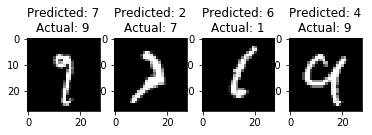

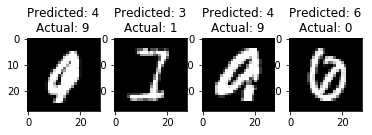

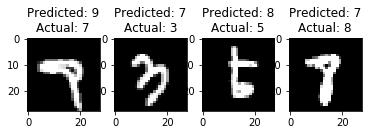

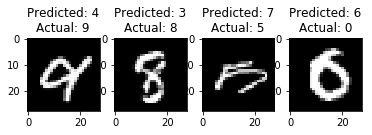

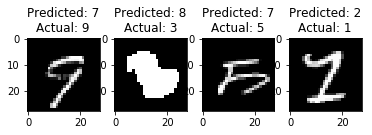

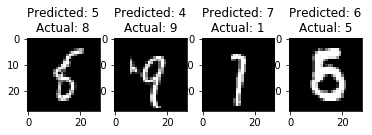

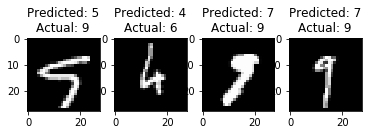

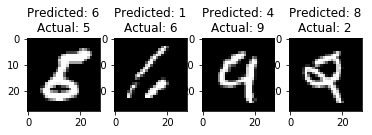

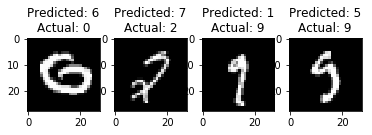

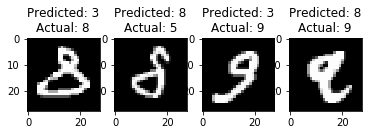

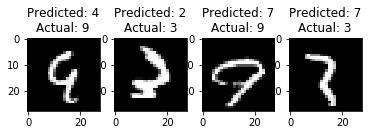

In [49]:
import matplotlib.pyplot as plt

pred=np.argmax(val_predictions, axis=1)
wrong_indices=np.where(np.argmax(val_predictions,axis=1)!=val_labels)[0]

for i in range(11):
    x=1
    f, axarr=plt.subplots(1,4)
    for i in wrong_indices[i*4:i*4+4]:
        axarr[x-1].imshow(val_X[i].reshape(28,28),cmap="gray")
        axarr[x-1].set_title("Predicted: "+str(pred[i])+"\nActual: "+str(val_labels[i]))
        x+=1
    plt.show(block=True)

In [55]:
sample['Label']=np.argmax(test_predictions,axis=1)

In [56]:
sample.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [59]:
sample.to_csv("Submissions.csv", index=False)

In [10]:
from keras.models import load_model

model=load_model("/kaggle/input/trained-models/MNIST_first.h5")

In [58]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)              